# Original code (DO NOT RUN)

In [ ]:
# Simulating the TDGL equation
# This example uses the 5-point Laplacian discretization from
# [here](https://github.com/ketch/finite-difference-course)

# from __future__ import division
import numpy as np
from scipy.sparse import spdiags,linalg,eye
import matplotlib.pyplot as plt


a,b, k = -1, 1.0, 100.0 #configuração: (a<0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 256, 10001
# Ng, Tf = 64, 10001
T = 0.1
master_list = []

class TDGL():
    '''
    Class to solve a PDE
    '''
    def mu(self, u):
        return a*u + b*u*u*u

    def laplacian(self, Ng):
        '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
        e=np.ones(Ng**2)
        e2=([1]*(Ng-1)+[0])*Ng
        e3=([0]+[1]*(Ng-1))*Ng
        h=dh
        A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-Ng,Ng],Ng**2,Ng**2)
        A/=h**2
        return A

    def integrate(self, L, x, y, u):
        '''  simulates the equation and plots it at different instants '''

        f = plt.figure(figsize=(15, 15), dpi=80);

        for i in range(Tf):
            noise = np.random.normal(loc=0.0, scale=1.0, size=(Ng*Ng, 1))
            u = u - dt*(self.mu(u) - k*L.dot(u)) + np.sqrt(2 * T * dt) * noise  # Euler's method

            # if (i==0):      self.configPlot(x, y, u, f, 1, i);
            # if (i==1):      self.configPlot(x, y, u, f, 2, i);
            # if (i==10):     self.configPlot(x, y, u, f, 3, i);
            # if (i==100):    self.configPlot(x, y, u, f, 4, i);
            # if (i==1000):   self.configPlot(x, y, u, f, 5, i);
            if (i==10000):
                #self.configPlot(x, y, u, f, 6, i)
                master_list.append(u)


    def configPlot(self, x, y, u,f, n_, i):
        U= u.reshape((Ng, Ng))
        sp =  f.add_subplot(3, 3, n_ )
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i)
    plt.show()

In [ ]:
rm = TDGL()   # instantiate the class
import json

# generate the grid and initialise the field
x = np.linspace(-1,1,Ng)
y = np.linspace(-1,1,Ng)
X, Y = np.meshgrid(x, y)

for i in range(2):
  u=np.random.randn(Ng*Ng, 1);  # Initial data
  L = rm.laplacian(Ng)         # construct the laplacian
  rm.integrate(L, x, y, u)    # simulate
  print(f'Time = {i+1}/2')

#simulation completed!!

# file_path = 'data.json'

# with open(file_path, 'w') as json_file:
#     json.dump(master_list, json_file)

Time = 1/2
Time = 2/2


TypeError: ignored

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [ ]:
master_list

[array([[-0.02520269],
        [ 0.02396397],
        [ 0.01209745],
        ...,
        [ 0.00581279],
        [ 0.00152299],
        [ 0.03385425]]),
 array([[ 0.00469987],
        [ 0.00758622],
        [ 0.04095446],
        ...,
        [-0.00938126],
        [ 0.01246062],
        [-0.01885348]])]

# Rewrite the code using Torch

## Verify if cuda is available using Torch

In [1]:
import torch

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a tensor and move it to the GPU
tensor_on_cpu = torch.rand(3, 3)
tensor_on_gpu = tensor_on_cpu.to(device)

# Perform operations on the GPU
result_tensor = tensor_on_gpu + 5

# Move the result back to the CPU if needed
result_on_cpu = result_tensor.cpu()


In [2]:
device

device(type='cuda')

## New laplacian code

In [88]:
import numpy as np
from scipy.sparse import lil_matrix
import torch

def create_laplacian_matrix(n):
    # Total number of grid points
    total_points = n * n

    laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

# Example usage
grid_size = 3  # Change this value to adjust the grid size
laplacian_matrix = create_laplacian_matrix(grid_size)

print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])


## Old laplacian code

In [89]:
import torch.sparse as sp
dh=1.0
dh = torch.tensor(dh, device='cuda')

def laplacian(Ng):
    # Constants
    h=dh

    e = torch.ones(Ng**2, dtype=torch.float32)

    # Create e2 using PyTorch
    e2 = (torch.tensor([1] * (Ng - 1) + [0], dtype=torch.float32).repeat(Ng)).type(torch.float32)

    # Create e3 using PyTorch
    e3 = (torch.tensor([0] + [1] * (Ng - 1), dtype=torch.float32).repeat(Ng)).type(torch.float32)
    size = (Ng*Ng, Ng*Ng)

    # Create the sparse diagonal matrix
    diagonals = torch.stack([-4 * e, e2, e3, e, e], dim=0)
    offsets = torch.tensor([0, -1, 1, -Ng, Ng], dtype=torch.int64)
    shape = (Ng**2, Ng**2)
    A = sp.spdiags(diagonals, offsets, shape)

    A /= h.item()**2

    #print("Sparse diagonal matrix:")
    return A

# Example usage
grid_size = 3  # Change this value to adjust the grid size
laplacian_matrix = laplacian(grid_size)
print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])


## Rewrite the original code using torch

In [90]:

# Simulating the TDGL equation

import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
import json


a,b, k = 1.0, 1.0, 100.0 #configuração: (a<0, b>0) ou (a>0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 256, 10001

a = torch.tensor(a, device='cuda')
b = torch.tensor(b, device='cuda')
k = torch.tensor(k, device='cuda')
dh = torch.tensor(dh, device='cuda')
dt = torch.tensor(dt, device='cuda')
Ng = torch.tensor(Ng, device='cuda')
Tf = torch.tensor(Tf, device='cuda')
T = torch.tensor([0.1], device='cuda')

# Ng, Tf = 64, 10001
master_list = []


def laplacian(n):
    # Total number of grid points
    total_points = n * n

    laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

# def laplacian(Ng):
#     # Constants
#     h=dh

#     e = torch.ones(Ng**2, dtype=torch.float32)

#     # Create e2 using PyTorch
#     e2 = (torch.tensor([1] * (Ng - 1) + [0], dtype=torch.float32).repeat(Ng)).type(torch.float32)

#     # Create e3 using PyTorch
#     e3 = (torch.tensor([0] + [1] * (Ng - 1), dtype=torch.float32).repeat(Ng)).type(torch.float32)
#     size = (Ng*Ng, Ng*Ng)

#     # Create the sparse diagonal matrix
#     diagonals = torch.stack([-4 * e, e2, e3, e, e], dim=0)
#     offsets = torch.tensor([0, -1, 1, -Ng, Ng], dtype=torch.int64)
#     shape = (Ng**2, Ng**2)
#     A = sp.spdiags(diagonals, offsets, shape)

#     A /= h.item()**2

#     #print("Sparse diagonal matrix:")
#     return A

def integrate(L, x, y, u):
    '''  simulates the equation and plots it at different instants '''

    #f = plt.figure(figsize=(15, 15), dpi=80);

    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cuda')
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method

        # if (i==0):      configPlot(x, y, u, f, 1, i);
        # if (i==1):      configPlot(x, y, u, f, 2, i);
        # if (i==10):     configPlot(x, y, u, f, 3, i);
        # if (i==100):    configPlot(x, y, u, f, 4, i);
        # if (i==1000):   configPlot(x, y, u, f, 5, i);
        if (i==10000):
            master_list.append(u)
            #configPlot(x, y, u, f, 6, i)


def configPlot(x, y, u,f, n_, i):
    u = u.view((Ng, Ng))
    u = u.cpu()
    U = u.numpy()
    sp =  f.add_subplot(3, 3, n_ )
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)
    plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i)


In [15]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cuda')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais

#L = L.to_dense()
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
for i in range(5):
  u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
  integrate(L, x, y, u)    # simulate
  print(f'Time = {i+1}/5')


## salva estas configurações em um arquivo JSON

mlist = [[] for _ in range(101)]
num = 0
for l in master_list:
    l = l.cpu()
    for i in range(len(l)):
        mlist[num].append(l[i].item())
    num+=1

file_path = 'data_configs_a_pos_b_pos.json'

with open(file_path, 'w') as json_file:
    json.dump(mlist, json_file)

KeyboardInterrupt: 

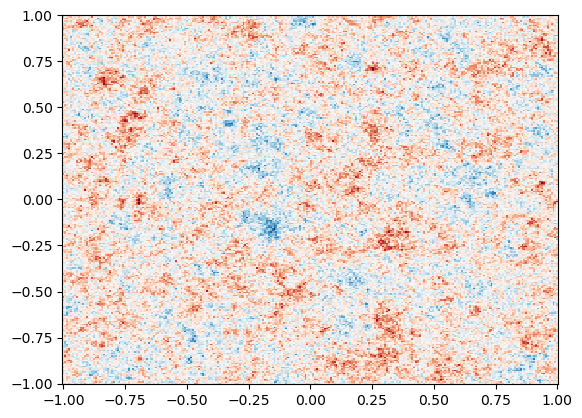

In [8]:
## visualizar a configuração final individualmente

u = master_list[2]
u = u.view((Ng, Ng))
u = u.cpu()
U = u.numpy()

plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu)

## code for retrive the json file

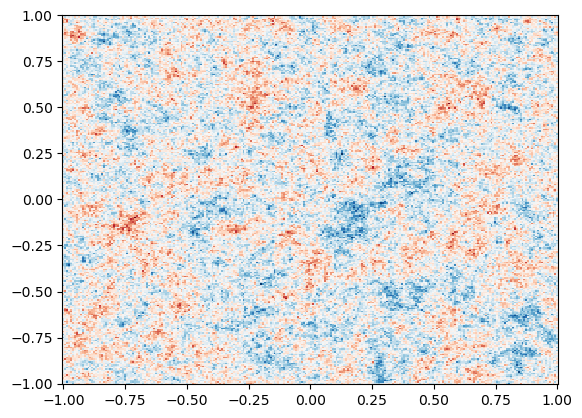

In [18]:
import numpy as np
import json
import torch

file_path = '../isin-data/data_configs_a_pos_b_pos.json'

with open(file_path, 'r') as arquivo_json:
    dados = json.load(arquivo_json)

dados = dados[:100]
dados = np.array(dados, dtype=float)
dados = torch.from_numpy(dados)

dataset = []
for i in range(len(dados)):
  dataset.append(dados[i].view((Ng,Ng)))

dataset[0]

x = np.linspace(-1,1,Ng)
y = np.linspace(-1,1,Ng)
plt.pcolormesh(x,y,dataset[1], cmap=plt.cm.RdBu)

In [19]:
import os 

diretorio = "../isin-data/high_temp"
os.makedirs(diretorio, exist_ok=True)

for i in range(len(dataset)):
    x = np.linspace(-1,1,Ng)
    y = np.linspace(-1,1,Ng)
    plt.pcolormesh(x,y,dataset[i], cmap=plt.cm.RdBu)
    file_name = f'{diretorio}/img_ht_{i}.jpg'

    # Save the plot as a PNG file
    plt.savefig(file_name)
    plt.close()

## correction for torch.sparse.spdiag



In [ ]:
import torch
n=5
device = torch.device('cuda')

w = torch.ones([n, 1]).T
W = torch.sparse.spdiags(w, torch.LongTensor([0]), (n, n)).to_dense()

W = W.to(device)
w = w.to(device)
A = torch.matmul(w, W)
print(A[0,0])

tensor(1., device='cuda:0')


In [ ]:
w = torch.ones([n, 1]).T
# when device use gpu , the following code will report an error
# but when device use cpu, the following code is right
W = torch.sparse.spdiags(w.to(device), torch.LongTensor([0]).to(device), (n, n)).to(device)

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

## Another Matrix Possibility

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# Define grid parameters
Nx, Ny = 5, 5
dx, dy = 1.0, 1.0

# Compute the Laplacian matrix in CSR format
data = []
indices = []
indptr = [0]

for i in range(Nx):
    for j in range(Ny):
        row = i * Ny + j  # Current row index
        # Central difference stencil
        data.extend([1.0 / dx**2, 1.0 / dy**2, -4.0 / (dx**2 + dy**2)])
        indices.extend([row, row - Ny, row + Ny, row - 1, row + 1])
        indptr.append(len(indices))

# Create the CSR matrix
# laplacian_matrix = csr_matrix((data, indices, indptr), shape=(Nx * Ny, Nx * Ny))

# # Print the Laplacian matrix
# print(laplacian_matrix.toarray())


In [ ]:
len(indices)

125